<a href="https://colab.research.google.com/github/cjrincon/Proyecto_Deep_Learning/blob/main/01_Exploraci%C3%B3n_de_datos_y_preprocesado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto Deep Learning**

El proyecto pretende predecir la vida útil remanente (RUL) en número de ciclos o tiempo que le resta a la batería a partir de la información recolectada de variables como:

**Datos de entrada**
- Ciclo
- Temperatura ambiente (°C)
- Fecha (fecha y hora de inicio del ciclo)
- Voltaje de la batería (Voltios)
- Corriente de la batería (Amperios)
- Temperatura de la batería (°C)
- Corriente de carga (Amperios)
- Voltaje de carga (Voltios)
- Tiempo (tiempo del ciclo en segundos)
- Capacidad de la batería (Amperios/h)
- Estado de salud (SOH) - Variable calculada en %

**Datos de salida**
- Vida Útil Remanente (RUL) - en ciclos

**Predicción:** se realizará a partir de diferentes modelos de deep learning, tomando como modelo base, una red LSTM para la predicción.


**Datos:** Se usa para la predicción un conjunto de datos de 4 baterías de la NASA. Disponibles en el enlace:
https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#battery

## Cargar las librerías necesarias para el desarrollo del proyecto

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

## Lectura de los datos

In [3]:
# Lectura de datos desde github

# Datos de la batería #5
url_5 = 'https://raw.githubusercontent.com/cjrincon/Proyecto_Deep_Learning/main/data/raw_data_05.csv'
bat_5 = pd.read_csv(url_5, delimiter=',')
# Datos de la batería #6
url_6 = 'https://raw.githubusercontent.com/cjrincon/Proyecto_Deep_Learning/main/data/raw_data_06.csv'
bat_6 = pd.read_csv(url_6, delimiter=',')
# Datos de la batería #7
url_7 = 'https://raw.githubusercontent.com/cjrincon/Proyecto_Deep_Learning/main/data/raw_data_07.csv'
bat_7 = pd.read_csv(url_7, delimiter=',')
# Datos de la batería #18
url_18 = 'https://raw.githubusercontent.com/cjrincon/Proyecto_Deep_Learning/main/data/raw_data_18.csv'
bat_18 = pd.read_csv(url_18, delimiter=',')

In [4]:
bat_5.head()

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,1,24,2008-04-02 15:25:41,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000
1,1,24,2008-04-02 15:25:41,1.856487,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781
2,1,24,2008-04-02 15:25:41,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703
3,1,24,2008-04-02 15:25:41,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781
4,1,24,2008-04-02 15:25:41,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922


In [5]:
# Se agrega una columna para identificar cada tipo de batería
bat_5 = bat_5.assign(battery=5)
bat_6 = bat_6.assign(battery=6)
bat_7 = bat_7.assign(battery=7)
bat_18 = bat_18.assign(battery=18)

In [6]:
# Se crea una base de datos consolidando los datos de las 4 baterías
data = pd.concat([bat_5, bat_6, bat_7, bat_18])
data

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,battery
0,1,24,2008-04-02 15:25:41,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,5
1,1,24,2008-04-02 15:25:41,1.856487,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,5
2,1,24,2008-04-02 15:25:41,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,5
3,1,24,2008-04-02 15:25:41,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,5
4,1,24,2008-04-02 15:25:41,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,5
...,...,...,...,...,...,...,...,...,...,...,...
34861,132,24,2008-08-20 08:37:19,1.341051,3.443760,-0.002426,35.383979,0.0006,0.000,2686.359,18
34862,132,24,2008-08-20 08:37:19,1.341051,3.453271,-0.000981,35.179732,0.0006,0.000,2700.546,18
34863,132,24,2008-08-20 08:37:19,1.341051,3.461963,0.000209,34.977000,0.0006,0.000,2714.640,18
34864,132,24,2008-08-20 08:37:19,1.341051,3.469907,0.001516,34.785943,0.0006,0.000,2728.750,18


## Análisis exploratorio de los datos

In [7]:
# Se valida el tipo de dato y si hay nulos en la base de datos
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185721 entries, 0 to 34865
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   cycle                 185721 non-null  int64  
 1   ambient_temperature   185721 non-null  int64  
 2   datetime              185721 non-null  object 
 3   capacity              185721 non-null  float64
 4   voltage_measured      185721 non-null  float64
 5   current_measured      185721 non-null  float64
 6   temperature_measured  185721 non-null  float64
 7   current_load          185721 non-null  float64
 8   voltage_load          185721 non-null  float64
 9   time                  185721 non-null  float64
 10  battery               185721 non-null  int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 17.0+ MB


In [8]:
# Se validan las medidas estadísticas de cada columna
data.describe()

,cycle,ambient_temperature,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,battery
count,185721.000000,185721.0,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000
mean,82.838758,24.0,1.574863,3.497219,-1.832569,32.378997,1.465434,2.366494,1546.379935,8.252799
std,45.692247,0.0,0.190633,0.251691,0.561405,4.027737,1.226874,0.751377,906.958628,4.743428
min,1.000000,24.0,1.153818,1.737030,-2.029098,22.350256,-2.000000,0.000000,0.000000,5.000000
25%,45.000000,24.0,1.426025,3.377653,-2.011418,29.570621,1.998200,2.410000,764.797000,5.000000
50%,81.000000,24.0,1.559634,3.500859,-2.009015,32.355737,1.998800,2.558000,1537.031000,6.000000
75%,120.000000,24.0,1.741850,3.655751,-1.989974,35.420677,1.999000,2.718000,2307.485000,7.000000
max,168.000000,24.0,2.035338,4.233325,0.014306,42.332522,2.000000,4.249000,3690.234000,18.000000


Se leen los datos, se crea una nueva columna para identificar los datos de cada una de las baterías: #5, #6, #7, #18 y se consolida la información de las 4 baterías en un dataset.

Según las validaciones, se tienen 185.721 filas en el dataset, no se tienen datos nulos en el dataset.

Según las medidas estadísticas del dataset, la temperatura ambiente es una constante para las 4 baterías y tiene un valor de 24. La variable capacidad tiene un mínimo de 1.15 y un máximo de 2.03 con una media de 1.57.



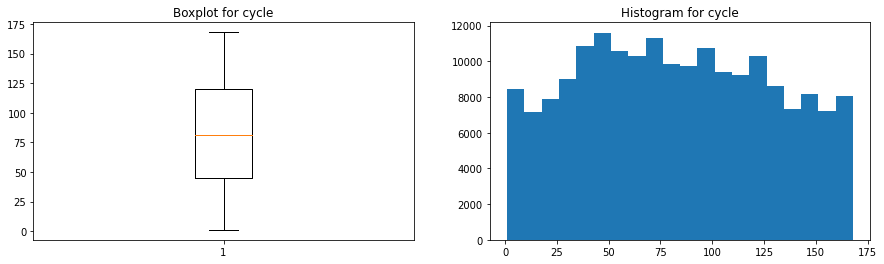

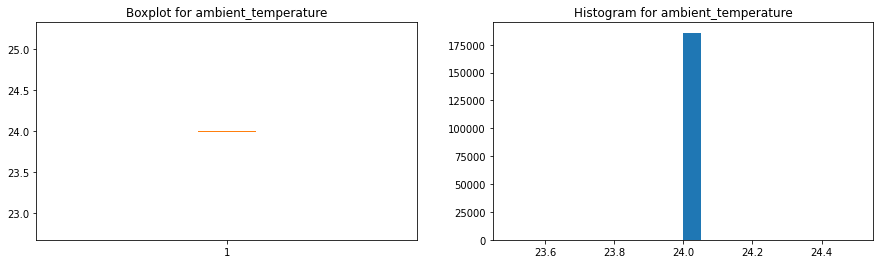

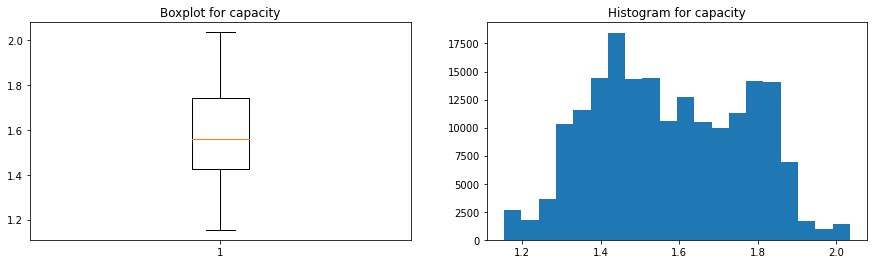

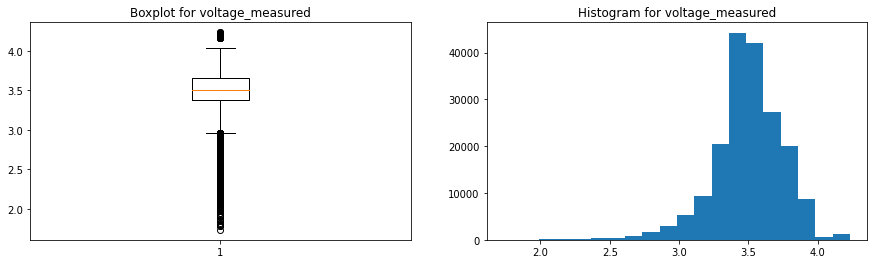

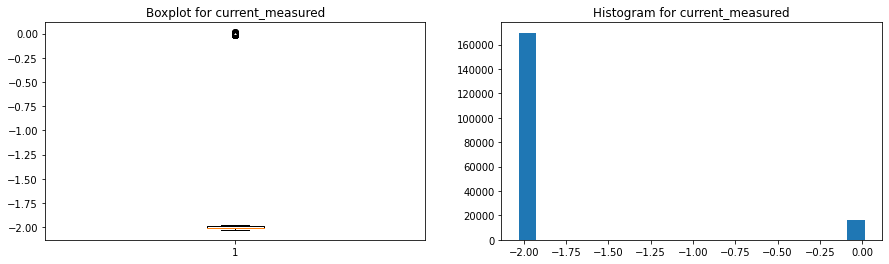

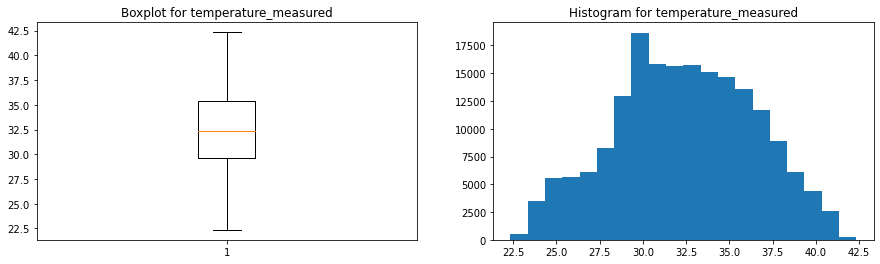

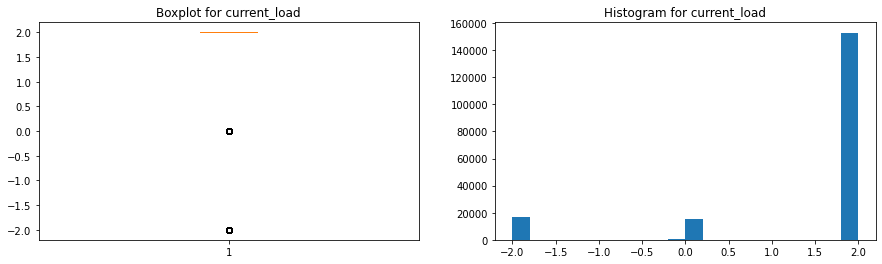

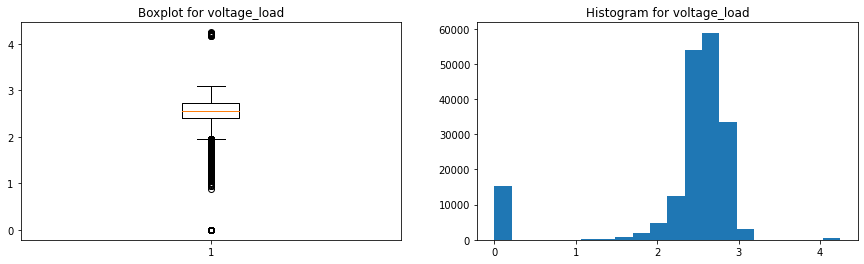

In [9]:
variables = ['cycle', 'ambient_temperature', 'capacity', 'voltage_measured', 'current_measured', 
                    'temperature_measured', 'current_load', 'voltage_load']
for var in variables:
    
    # Se crea el espacio para los gráficos
    fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

    # Se extraen los valores para cada variable
    x = data[var].values

    # Se grafica el boxplot
    ax1.boxplot(x)
    ax1.set_title( 'Boxplot for {}'.format(var) )

    # Se grafica el histograma
    ax2.hist(x, bins=20)
    ax2.set_title( 'Histogram for {}'.format(var) )
    plt.show()

Según los gráficos se observa:

- La temperatura ambiente es constante con un valor de 24
- El voltaje medido tiene una distribución con cola pesada hacia la izquierda
- La corriente medida tiene pocos datos con valor de 0, y la mayoría de los datos está distribuido alrededor de -2
- La temperatura medida pareciera seguir una distribución normal
- La corriente de carga tiene valores entre -2, 0 y 2, donde la mayoría de los datos está distribuido alrededor de 2
- El voltaje de carga tiene valores en 0 y la mayoría distribuido entre 2 y 3




## Matriz de correlaciones

In [10]:
# Matriz de correlaciones
corr_data = data.loc[:,data.columns!='ambient_temperature'].corr()
print(corr_data, "\n")

                         cycle  capacity  voltage_measured  current_measured  \
cycle                 1.000000 -0.924433         -0.142041          0.132452   
capacity             -0.924433  1.000000          0.165433         -0.163532   
voltage_measured     -0.142041  0.165433          1.000000         -0.083980   
current_measured      0.132452 -0.163532         -0.083980          1.000000   
temperature_measured  0.152562 -0.137249         -0.885815          0.318778   
current_load          0.369781 -0.387503         -0.037141         -0.366280   
voltage_load         -0.185969  0.221651          0.416026         -0.896695   
time                 -0.115680  0.115478         -0.796901          0.358933   
battery              -0.237778  0.045500          0.007748         -0.019430   

                      temperature_measured  current_load  voltage_load  \
cycle                             0.152562      0.369781     -0.185969   
capacity                         -0.137249     -0.3

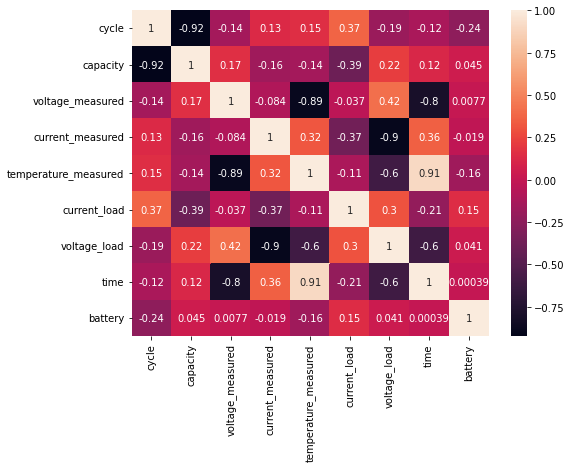

In [11]:
# Se grafica la matriz de correlaciones
plt.figure(figsize=(8, 6))
sns.heatmap(corr_data, annot=True) # , cmap='YlGnBu'
plt.show()

Según la matriz de correlaciones, se observan relaciones fuertes directas entre las variables *temperatura medida y tiempo*, con una correlación del 91%, lo que indica que a medida que aumenta el tiempo, aumenta la temperatura.

Así mismo, se observan relaciones inversas fuertes entre las variables:
- *Ciclo y capacidad* con una correlación del 92%, lo cual tiene sentido, ya que a medida que aumentan los ciclos de carga/descarga, disminuye la capacidad.

- *Temperatura y voltaje medidos* con una correlación del 89%, lo que indica que a medida que aumenta la temperatura, disminuye el voltaje.

- *Tiempo y voltaje medido* con una correlación del 80%, que indica que a medida que aumenta el tiempo, disminuye el voltaje.

- *Voltaje de carga y corriente medida* con una correlación del 90%. A medida que aumenta una de las variables, disminuye la otra.



Text(0.5, 1.0, 'Capacidad de la batería a través de los ciclos')

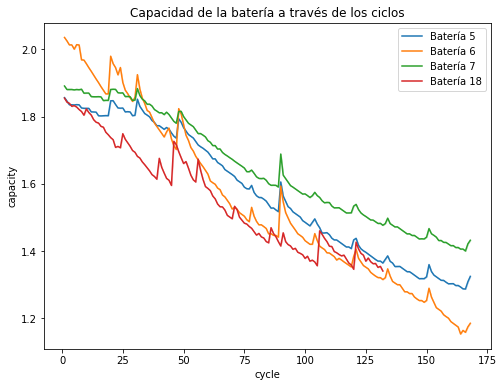

In [12]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='cycle', y='capacity', data=data[data['battery'] == 5], label = 'Batería 5')
sns.lineplot(x='cycle', y='capacity', data=data[data['battery'] == 6], label = 'Batería 6')
sns.lineplot(x='cycle', y='capacity', data=data[data['battery'] == 7], label = 'Batería 7')
sns.lineplot(x='cycle', y='capacity', data=data[data['battery'] == 18], label = 'Batería 18')
plt.title("Capacidad de la batería a través de los ciclos")

In [13]:
data['datetime'] = pd.to_datetime(data['datetime'])

Text(0.5, 1.0, 'Voltaje medido de la batería a través del tiempo')

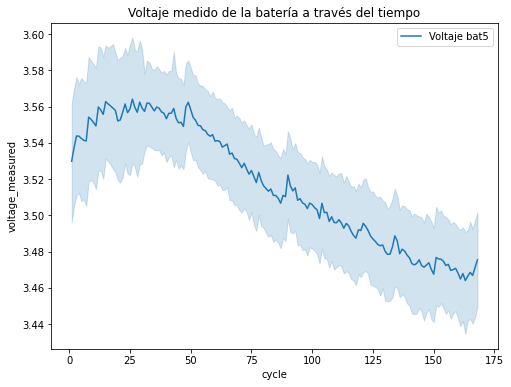

In [14]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='cycle', y='voltage_measured', data=data[data['battery'] == 5], label = 'Voltaje bat5')
plt.title("Voltaje medido de la batería a través del tiempo")

Text(0.5, 1.0, 'Corriente medida de la batería a través del tiempo')

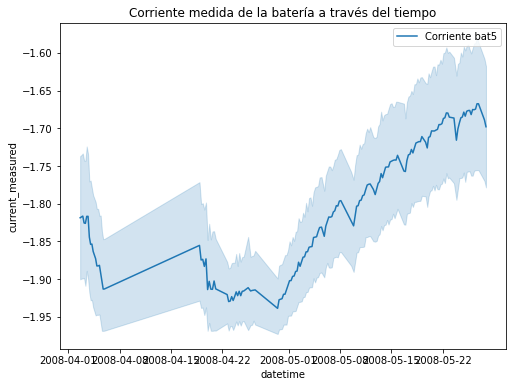

In [15]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='datetime', y='current_measured', data=data[data['battery'] == 5], label = 'Corriente bat5')
plt.title("Corriente medida de la batería a través del tiempo")

Text(0.5, 1.0, 'Temperatur medida de la batería a través del tiempo')

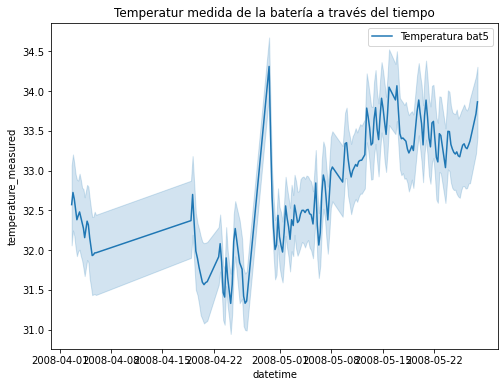

In [16]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='datetime', y='temperature_measured', data=data[data['battery'] == 5], label = 'Temperatura bat5')
plt.title("Temperatur medida de la batería a través del tiempo")

## Cálculo del estado de salud - SOH

Teniendo en cuenta que el SOH de una batería se puede calcular a partir de la capacidad de la misma, se define el SOH como:

$$ SOH = \frac{Ck}{Co} *100 $$

Donde:

*Ck:* Indica la capadidad actual en el ciclo k

*Co:* Indica la capacidad al inicio de la vida de la batería





In [18]:
# Se calcula el SOH según la fórmula anterior
bat_5['SOH'] = bat_5['capacity']/bat_5['capacity'][0]
bat_6['SOH'] = bat_6['capacity']/bat_6['capacity'][0]
bat_7['SOH'] = bat_7['capacity']/bat_7['capacity'][0]
bat_18['SOH'] = bat_18['capacity']/bat_18['capacity'][0]

In [19]:
data = pd.concat([bat_5, bat_6, bat_7, bat_18])

In [20]:
data.describe()

,cycle,ambient_temperature,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,battery,SOH
count,185721.000000,185721.0,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000
mean,82.838758,24.0,1.574863,3.497219,-1.832569,32.378997,1.465434,2.366494,1546.379935,8.252799,0.824538
std,45.692247,0.0,0.190633,0.251691,0.561405,4.027737,1.226874,0.751377,906.958628,4.743428,0.107054
min,1.000000,24.0,1.153818,1.737030,-2.029098,22.350256,-2.000000,0.000000,0.000000,5.000000,0.566893
25%,45.000000,24.0,1.426025,3.377653,-2.011418,29.570621,1.998200,2.410000,764.797000,5.000000,0.746576
50%,81.000000,24.0,1.559634,3.500859,-2.009015,32.355737,1.998800,2.558000,1537.031000,6.000000,0.821478
75%,120.000000,24.0,1.741850,3.655751,-1.989974,35.420677,1.999000,2.718000,2307.485000,7.000000,0.917934
max,168.000000,24.0,2.035338,4.233325,0.014306,42.332522,2.000000,4.249000,3690.234000,18.000000,1.000000


Text(0.5, 1.0, 'SOH de la batería a través de los ciclos')

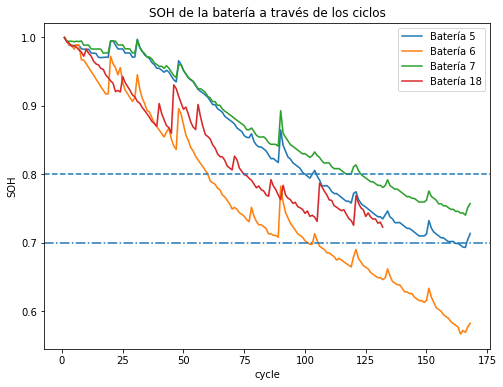

In [21]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='cycle', y='SOH', data=data[data['battery'] == 5], label = 'Batería 5')
sns.lineplot(x='cycle', y='SOH', data=data[data['battery'] == 6], label = 'Batería 6')
sns.lineplot(x='cycle', y='SOH', data=data[data['battery'] == 7], label = 'Batería 7')
sns.lineplot(x='cycle', y='SOH', data=data[data['battery'] == 18], label = 'Batería 18')
plt.axhline(0.8, linestyle='--')
plt.axhline(0.7, linestyle='-.')
plt.title("SOH de la batería a través de los ciclos")

In [22]:
# Se valida el número de ciclos por batería
data.groupby('battery')['cycle'].max()

battery
5     168
6     168
7     168
18    132
Name: cycle, dtype: int64

In [23]:
# Se valida la capacidad inicial de cada una de las baterías
data.groupby('battery')['capacity'].max()

battery
5     1.856487
6     2.035338
7     1.891052
18    1.855005
Name: capacity, dtype: float64

In [24]:
# El valor mínimo del SOH de cada batería
data.groupby('battery')['SOH'].min()

battery
5     0.693488
6     0.566893
7     0.740569
18    0.722937
Name: SOH, dtype: float64

Las baterías #5, #6 y #7 se midieron por 168 ciclos y la batería #18, se midió hasta el ciclo 132.

Cada una de las baterías inició con una capacidad diferente. La batería #6 es que muestra mayor capacidad inicial, seguida por la batería #7, luego la batería #5 y finalmente, la batería #18.

## Nuevo dataset

Se crea un nuevo dataset con el mínimo, máximo, promedio y desviación estándar de las variables temperatura, voltaje y corriente medidas y voltaje y corriente de carga, además de la capacidad

In [149]:
dataset_5 = bat_5.groupby(by=['cycle'])[['temperature_measured', 'voltage_measured', 'current_measured', 'voltage_load', 'current_load']].agg([min, max, np.mean, np.std])
dataset_5['capacity'] = bat_5.groupby(by=['cycle'])['capacity'].mean()
dataset_5.head()

temperature_measured                                 voltage_measured  \
                       min        max       mean       std              min   
cycle                                                                         
1                24.325993  38.982181  32.572328  3.495804         2.612467   
2                24.685948  39.033398  32.725235  3.435509         2.587209   
3                24.734266  38.818797  32.642862  3.388174         2.651917   
4                24.652244  38.762305  32.514876  3.395306         2.592948   
5                24.518700  38.665393  32.382349  3.404667         2.547420   

                                    current_measured            ...            \
            max      mean       std              min       max  ...       std   
cycle                                                           ...             
1      4.191492  3.529829  0.236558        -2.018015  0.000729  ...  0.595058   
2      4.189773  3.537320  0.235366        -2.016821  0.002927  ...  0.596704   
3      4.188187  3.543737  0.228111        -2.016574  0.001484  ...  0.598033   
4      4.188461  3.543666  0.233347        -2.015936  0.001547  ...  0.584972   
5      4.188299  3.542343  0.237301        -2.017426  0.001701  ...  0.584978   

      voltage_load                            current_load                    \
               min    max      mean       std          min     max      mean   
cycle                                                                          
1              0.0  4.206  2.404944  0.796974      -1.9984 -0.0004 -1.805570   
2              0.0  4.204  2.399260  0.796596      -1.9984 -0.0006 -1.804583   
3              0.0  4.203  2.397969  0.797389      -1.9984 -0.0004 -1.803575   
4              0.0  4.203  2.408289  0.780677      -1.9984 -0.0006 -1.812863   
5              0.0  4.203  2.408505  0.781348      -1.9984 -0.0006 -1.812876   

                 capacity  
            std            
cycle                      
1      0.591217  1.856487  
2      0.592561  1.846327  
3      0.593925  1.835349  
4      0.581063  1.835263  
5      0.581067  1.834646  

[5 rows x 21 columns]

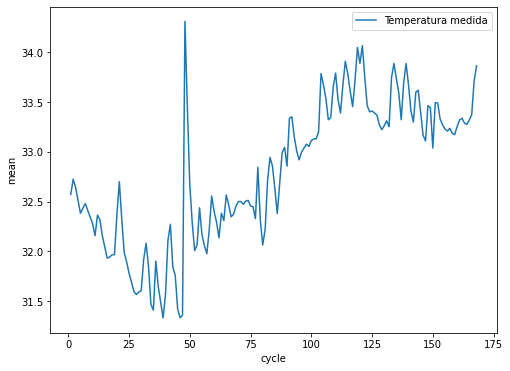

In [153]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='cycle', y='mean', data=dataset_5['temperature_measured'], label = 'Temperatura medida')

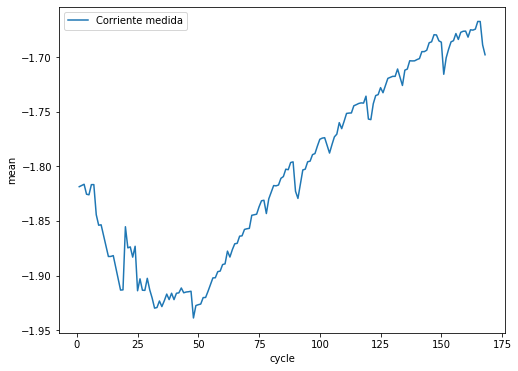

In [154]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='cycle', y='mean', data=dataset_5['current_measured'], label = 'Corriente medida')

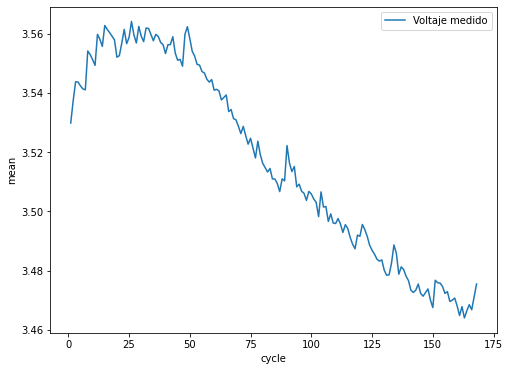

In [150]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='cycle', y='mean', data=dataset_5['voltage_measured'], label = 'Voltaje medido')